# Automatic Ticket Classification - Case Strudy

## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import sklearn
print(sklearn.__version__)

1.4.2


In [2]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import RocCurveDisplay

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [3]:
# Opening JSON file 
f = open('complaints-2021-05-14_08_16.json') # Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [4]:
# Inspect the dataframe to understand the given data.
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [5]:
# print the column names
pprint(df.columns)

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')


In [6]:
#Assign new column names
# removed all the _source. from the column names to create new names
df.columns = ['index', 'type', 'id', 'score', 'tags', 'zip_code',
       'complaint_id', 'issue', 'date_received',
       'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via',
       'date_sent_to_company', 'company_public_response',
       'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue',
       'consumer_consent_provided']

In [7]:
#Assign nan in place of blanks in the complaints column
df[df.loc[:, 'complaint_what_happened'] == ''] = np.nan

In [8]:
# validate if all blanks are marked as nan
df[df.loc[:,'complaint_what_happened']=='']

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided


In [9]:
#before we remove all the nan, lets take a count
df.shape

(78313, 22)

In [10]:
#Remove all rows where complaints column is nan
df = df[~df['complaint_what_happened'].isnull()]

In [11]:
# validate the if all nan is removed by taking the count and comparing with the earlier count
df.shape

(21072, 22)

In [12]:
df['complaint_what_happened'].head(10)

1     Good morning my name is XXXX XXXX and I apprec...
2     I upgraded my XXXX XXXX card in XX/XX/2018 and...
10    Chase Card was reported on XX/XX/2019. However...
11    On XX/XX/2018, while trying to book a XXXX  XX...
14    my grand son give me check for {$1600.00} i de...
15                        Can you please remove inquiry
17    With out notice J.P. Morgan Chase restricted m...
20    During the summer months, I experience a decli...
21    On XXXX XX/XX/2019, I made a {$300.00} payment...
23    I have a Chase credit card which is incorrectl...
Name: complaint_what_happened, dtype: object

#### After removing all the blanks we have only 21072 rows

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [13]:
df['complaint_what_happened'] = df['complaint_what_happened'].astype(str)

In [14]:
df['complaint_what_happened'].head(10)

1     Good morning my name is XXXX XXXX and I apprec...
2     I upgraded my XXXX XXXX card in XX/XX/2018 and...
10    Chase Card was reported on XX/XX/2019. However...
11    On XX/XX/2018, while trying to book a XXXX  XX...
14    my grand son give me check for {$1600.00} i de...
15                        Can you please remove inquiry
17    With out notice J.P. Morgan Chase restricted m...
20    During the summer months, I experience a decli...
21    On XXXX XX/XX/2019, I made a {$300.00} payment...
23    I have a Chase credit card which is incorrectl...
Name: complaint_what_happened, dtype: object

In [15]:
# Write your function here to clean the text and remove all the unnecessary elements.
# planning to use the below steps tp clean up the text
# 1. convert to lower case
# 2. remove all punctuations
# 3. remove all spl characters
# 4. remove all numbers in the words

def cleanTxt(clnTxt):
    print("Here 1")
    clnTxt = clnTxt.lower()
    #regex for not a waord
    pattern = '[^\w\s]'
    clnTxt = re.sub(pattern, '', clnTxt)
    print("Here 2")

    #regex for words with digits
    pattern = '\w*\d\w*'
    clnTxt = re.sub(pattern, '',clnTxt)
    print("Here 3")

    #regex for words with spl character
    pattern = '\b\w*[^a-zA-Z0-9\s]+\w*\b'
    clnTxt = re.sub(pattern, '',clnTxt)
   # print ("Here 4")

    return clnTxt


In [16]:
#Write your function to Lemmatize the texts

def lemmatizeTxt(text):
    clnTxt = []
    doc = nlp(text)
    for token in doc:
        clnTxt.append(token.lemma_)

    return " ".join(clnTxt)


In [17]:
df_clean1 = pd.DataFrame(df['complaint_what_happened'].apply(cleanTxt))

Here 1
Here 2
Here 3
Here 1
Here 2
Here 3
Here 1
Here 2
Here 3
Here 1
Here 2
Here 3
Here 1
Here 2
Here 3
Here 1
Here 2
Here 3
Here 1
Here 2
Here 3
Here 1
Here 2
Here 3
Here 1
Here 2
Here 3
Here 1
Here 2
Here 3
Here 1
Here 2
Here 3
Here 1
Here 2
Here 3
Here 1
Here 2
Here 3
Here 1
Here 2
Here 3
Here 1
Here 2
Here 3
Here 1
Here 2
Here 3
Here 1
Here 2
Here 3
Here 1
Here 2
Here 3
Here 1
Here 2
Here 3
Here 1
Here 2
Here 3
Here 1
Here 2
Here 3
Here 1
Here 2
Here 3
Here 1
Here 2
Here 3
Here 1
Here 2
Here 3
Here 1
Here 2
Here 3
Here 1
Here 2
Here 3
Here 1
Here 2
Here 3
Here 1
Here 2
Here 3
Here 1
Here 2
Here 3
Here 1
Here 2
Here 3
Here 1
Here 2
Here 3
Here 1
Here 2
Here 3
Here 1
Here 2
Here 3
Here 1
Here 2
Here 3
Here 1
Here 2
Here 3
Here 1
Here 2
Here 3
Here 1
Here 2
Here 3
Here 1
Here 2
Here 3
Here 1
Here 2
Here 3
Here 1
Here 2
Here 3
Here 1
Here 2
Here 3
Here 1
Here 2
Here 3
Here 1
Here 2
Here 3
Here 1
Here 2
Here 3
Here 1
Here 2
Here 3
Here 1
Here 2
Here 3
Here 1
Here 2
Here 3
Here 1
Here 2

In [18]:
df_clean1

,complaint_what_happened
1,good morning my name is xxxx xxxx and i apprec...
2,i upgraded my xxxx xxxx card in and was told ...
10,chase card was reported on however fraudulent...
11,on while trying to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...
...,...
78303,after being a chase card customer for well ove...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...
78310,i am not familiar with xxxx pay and did not un...
78311,i have had flawless credit for yrs ive had ch...


In [19]:
df_clean1['complaint_lemma'] = df_clean1['complaint_what_happened'].apply(lemmatizeTxt)

In [20]:
df_clean1

,complaint_what_happened,complaint_lemma
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...
...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...


In [21]:
#importing TextBlob
#!pip install textblob


In [22]:
from textblob import TextBlob

In [23]:
# install wordcloud
#!pip install wordcloud

In [24]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [25]:
import pickle

In [26]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sanil\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\sanil\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [27]:
#Write your function to extract the POS tags 

def pos_tag(text):
  # write your code here
    finalTxt = []
    blobTxt = TextBlob(text)
    finalTxt = [word for (word,tag) in blobTxt.tags if tag=='NN']
    return " ".join(finalTxt)


In [28]:
df_clean1["complaint_POS_removed"] =  df_clean1['complaint_lemma'].apply(pos_tag)#this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].

In [29]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean1

,complaint_what_happened,complaint_lemma,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...
...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,visa credit card provider claim purchase prote...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit yrs credit card chase freedom xxxx prob...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




C:\Users\sanil\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



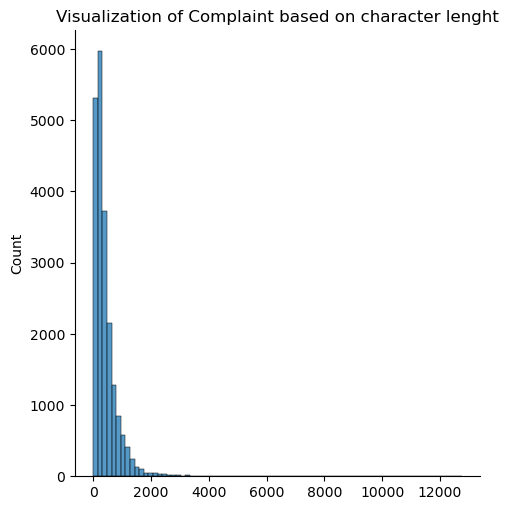

In [30]:
# Write your code here to visualise the data according to the 'Complaint' character length
complaint_length = [len(eachTxt) for eachTxt in df_clean1['complaint_POS_removed']]

sns.displot(complaint_length, kind='hist', bins=80)
plt.title('Visualization of Complaint based on character lenght')
plt.show()

### Skewed distribution

#### Find the top 40 words by frequency among all the articles after processing the text.

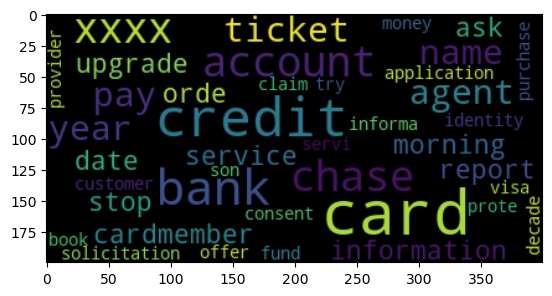

In [31]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
stopwords = set(STOPWORDS)
wordcloud = WordCloud(max_font_size=50, max_words=40,stopwords=stopwords).generate(str(df_clean1['complaint_POS_removed']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

### Some of the top words are Card, credit, bank, account

In [32]:
#Removing -PRON- from the text corpus
df_clean1['Complaint_clean'] = df_clean1['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

#### Since we need to fing unigram, bigram and trigram, creating a func

In [33]:
# func to find the unigram, bigram, trigram
def get_ngrams(text, n=None, ngram=(1,1)):
    vec = CountVectorizer(stop_words='english', ngram_range=ngram).fit(text)
    bow = vec.transform(text)
    sumWords = bow.sum(axis=0)
    wordFreq = [(word, sumWords[0,i]) for word, i in vec.vocabulary_.items()]
    wordFrequency = sorted(wordFreq, key = lambda x:x[1], reverse=True)
    return wordFrequency[:n]
    

In [34]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
top30 = get_ngrams(df_clean1['Complaint_clean'].values.astype('U'), n=30,ngram=(1,1))
df_unigram = pd.DataFrame(top30, columns=['unigram','count'])

In [35]:
df_unigram

,unigram,count
0,account,47523
1,chase,46710
2,xxxx,36583
3,credit,34154
4,card,29289
5,bank,28410
6,payment,21170
7,time,16027
8,charge,15000
9,day,12977


In [36]:
#Print the top 10 words in the unigram frequency
df_unigram.head(10)

,unigram,count
0,account,47523
1,chase,46710
2,xxxx,36583
3,credit,34154
4,card,29289
5,bank,28410
6,payment,21170
7,time,16027
8,charge,15000
9,day,12977


In [37]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
top30 = get_ngrams(df_clean1['Complaint_clean'].values.astype('U'), n=30,ngram=(2,2))
df_bigram = pd.DataFrame(top30, columns=['bigram','count'])

In [38]:
#Print the top 10 words in the bigram frequency
df_bigram.head(10)

,bigram,count
0,credit card,12781
1,credit report,3955
2,xxxx xxxx,3951
3,customer service,3081
4,chase credit,2966
5,chase bank,2940
6,bank account,2728
7,account chase,2595
8,chase account,2564
9,check account,2413


In [39]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
top30 = get_ngrams(df_clean1['Complaint_clean'].values.astype('U'), n=30,ngram=(3,3))
df_trigram = pd.DataFrame(top30, columns=['trigram','count'])

In [40]:
#Print the top 10 words in the trigram frequency
df_trigram.head(10)

,trigram,count
0,chase credit card,2063
1,credit card account,1023
2,credit card company,992
3,credit card chase,632
4,credit card credit,515
5,inquiry credit report,481
6,charge credit card,421
7,xxxx xxxx xxxx,411
8,account credit card,398
9,card credit card,388


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [41]:
df_clean1['Complaint_clean'] = df_clean1['Complaint_clean'].str.replace('xxxx','')

In [42]:
#All masked texts has been removed
df_clean1

,complaint_what_happened,complaint_lemma,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...
...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit yrs credit card chase freedom xxxx prob...,credit yrs credit card chase freedom problem ...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [43]:
#Write your code here to initialise the TfidfVectorizer 
#from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df=2, max_df=0.95,stop_words='english')


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [44]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
docTrmMtrx = tfidf.fit_transform(df_clean1['Complaint_clean'])


In [45]:
docTrmMtrx

<21072x7267 sparse matrix of type '<class 'numpy.float64'>'
	with 643743 stored elements in Compressed Sparse Row format>

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [46]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [47]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

nmf_model = NMF(n_components=num_topics, random_state=40)#write your code here

In [48]:
nmf_model.fit(docTrmMtrx)
len(tfidf.get_feature_names_out())

7267

In [49]:
H = nmf_model.components_

In [50]:
#Print the Top15 words for each of the topics

words = np.array(tfidf.get_feature_names_out())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words


,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,bank,check,money,fund,chase,deposit,branch,day,number,business,transaction,claim,transfer,customer
Topic 2,credit,card,report,inquiry,chase,account,score,company,limit,information,debt,application,letter,year,balance
Topic 3,payment,balance,month,fee,statement,day,time,auto,date,pay,credit,account,chase,year,mortgage
Topic 4,charge,card,fee,transaction,dispute,chase,merchant,fraud,claim,purchase,service,time,statement,refund,company
Topic 5,loan,mortgage,home,modification,chase,property,year,letter,rate,time,document,bank,house,foreclosure,sale


#### Frpm the table above 
- Topic1 seems to be related to bank accounts
- Topic2 card services
- Topic3 Misc
- Topic4 Frauds and Disputes
- Topic5 Loans and Mortages

In [51]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_results = nmf_model.transform(docTrmMtrx)


In [52]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean1['Topic'] = topic_results.argmax(axis=1)#write your code to assign topics to each rows.

In [56]:
df_clean1.head()

,complaint_what_happened,complaint_lemma,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,1
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0


In [57]:
df_clean1.shape

(21072, 5)

In [58]:
#Print the first 5 Complaint for each of the Topics
df_clean_sampl1=df_clean1.groupby('Topic').head(5)
df_clean_sampl1.sort_values('Topic')

,complaint_what_happened,complaint_lemma,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,jp chase account debit card tuesday thursday b...,jp chase account debit card tuesday thursday b...,0
24,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xxxx,mishandle account auto xxxx,mishandle account auto,0
27,i opened an account with chase bank on xxxx an...,I open an account with chase bank on xxxx and ...,account bank code bonus term everything accoun...,account bank code bonus term everything accoun...,0
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,1
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
15,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,1
23,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...,chase credit card datum credit report company ...,chase credit card datum credit report company ...,1


In [59]:
df_clean1.shape

(21072, 5)

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [60]:
#Create the dictionary of Topic names and Topics

Topic_names = {  0:"Bank account services", 1:"Credit card / Prepaid card", 2:"Others", 3:"Theft/Dispute reporting", 4:"Mortgages/loans"   }
#Replace Topics with Topic Names
df_clean1 = df_clean1.copy()
df_clean1['Topic'] = df_clean1['Topic'].map(Topic_names)
#df_clean.loc[:, 'Topic'] = df_clean['Topic'].map(Topic_names)

#df_clean = df_clean.copy()
#df_clean.loc[:, 'Topic'] = df_clean['Topic'].map(Topic_names)

In [61]:
df_clean1.shape

(21072, 5)

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [64]:
#Create the dictionary again of Topic names and Topics

Topic_names = {  "Bank account services":0, "Credit card / Prepaid card":1, "Others":2, "Theft/Dispute reporting":3, "Mortgages/loans":4  }
#Replace Topics with Topic Names
df_clean1 = df_clean1.copy()
df_clean1['Topic'] = df_clean1['Topic'].map(Topic_names)
#df_clean.loc[:, 'Topic'] = df_clean['Topic'].map(Topic_names)

#df_clean = df_clean.copy()
#df_clean.loc[:, 'Topic'] = df_clean['Topic'].map(Topic_names)

In [65]:
df_clean1.shape

(21072, 5)

In [66]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean1[['complaint_what_happened', 'Topic']]

In [67]:
training_data

,complaint_what_happened,Topic
1,good morning my name is xxxx xxxx and i apprec...,0
2,i upgraded my xxxx xxxx card in and was told ...,1
10,chase card was reported on however fraudulent...,1
11,on while trying to book a xxxx xxxx ticket ...,1
14,my grand son give me check for i deposit it i...,0
...,...,...
78303,after being a chase card customer for well ove...,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,3
78310,i am not familiar with xxxx pay and did not un...,3
78311,i have had flawless credit for yrs ive had ch...,2


#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [68]:
#Write your code to get the Vector count
vect = CountVectorizer()
X_train_cnt = vect.fit_transform(training_data['complaint_what_happened'])


# Save word vector
pickle.dump(vect.vocabulary_, open("count_vector.pk1", "wb"))


In [69]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_cnt)

# Save tfidf
pickle.dump(tfidf_transformer, open('tfidf.pk1', "wb"))

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

## Logistic Regression

In [70]:
# Write your code here to build any 3 models and evaluate them using the required metrics

# Importing LogisticRegression from sklearn
from sklearn.linear_model import LogisticRegression
# Importing Train, Test Split
from sklearn.model_selection import train_test_split



In [71]:
# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data['Topic'], test_size=0.25, random_state=35)

In [72]:
logistreg = LogisticRegression(random_state=42, solver='liblinear').fit(X_train, y_train)

In [73]:
# Getting the score of the base model
logistreg.score(X_test, y_test)

0.920083523158694

#### We got a score of 92% on Logistic Regression

#### Hyper Parameter Tuning

In [74]:
logreg_grid = {"C": [90, 10, 5, 4, 3, 2, 1, 1.0, 0.1, 0.01],"solver": ["liblinear"]}

In [75]:
# Setup grid hyperparameter search for LogisticRegression
logreg_hpt = GridSearchCV(LogisticRegression(random_state=42), param_grid=logreg_grid,
                                cv=5,verbose=True, n_jobs=-1)

# Fit random hyperparameter search model
logreg_hpt.fit(X_train, y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [76]:
# Check best parameters
logreg_hpt.best_params_

{'C': 3, 'solver': 'liblinear'}

In [77]:
# Evaluating the tuned model
logreg_hpt.score(X_test, y_test)

0.925208807896735

With tuning we saw some slight improvements only from 92% to 92.5%

In [78]:
# Save Logistic Regression Model
pickle.dump(logreg_hpt, open("logreg_model.pk1", "wb"))

#### Lets evaluate the model

In [79]:
# Load model
logreg_model = pickle.load(open("logreg_model.pk1", "rb"))

In [80]:
# Lets predict on test data
y_pred = logreg_model.predict(X_test)

In [81]:
# Confusion Matrix
print(confusion_matrix(y_test, y_pred))

[[1220   22    3   33    6]
 [  20 1162    6   44    8]
 [  15   14  497   27   21]
 [  51   42   10 1115   16]
 [  26   13    4   13  880]]


In [82]:
targetTopicnames = ["Bank account services", "Credit card / Prepaid card", "Others", "Theft/Dispute reporting", "Mortgages/loans"]

In [83]:
# Classification Report
print(classification_report(y_test, y_pred, target_names = targetTopicnames))

                            precision    recall  f1-score   support

     Bank account services       0.92      0.95      0.93      1284
Credit card / Prepaid card       0.93      0.94      0.93      1240
                    Others       0.96      0.87      0.91       574
   Theft/Dispute reporting       0.91      0.90      0.90      1234
           Mortgages/loans       0.95      0.94      0.94       936

                  accuracy                           0.93      5268
                 macro avg       0.93      0.92      0.92      5268
              weighted avg       0.93      0.93      0.93      5268



- The overall accuracy of the LR model is 92%.
- 
Precision and Recall are933% and922% respectivel.

## Decision Tree Classifier

In [84]:
# Importing DecisionTreeClassifier from sklearn
from sklearn.tree import DecisionTreeClassifier

In [85]:
# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data['Topic'], test_size=0.25, random_state=42)

In [86]:
dt = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

In [87]:
# Getting the score of the base model
dt.score(X_test, y_test)

0.7761958997722096

#### DT Model gave an accuracy of 77%.

#### Hyper Parameter Tuning

In [88]:
dt_grid = {"max_depth": [3, 5, 10], "min_samples_split": np.arange(2, 20, 2), "min_samples_leaf": np.arange(1, 20, 2)}

In [89]:
# grid hyperparameter search for LR
dt_hpt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid=dt_grid, cv=5, verbose=True, n_jobs=-1)

# Fit model
dt_hpt.fit(X_train, y_train);

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


In [90]:
# Check best parameters
dt_hpt.best_params_

{'max_depth': 10, 'min_samples_leaf': 13, 'min_samples_split': 2}

In [91]:
# Lets valuate the model
dt_hpt.score(X_test, y_test)

0.7723993925588458

#### Even after tuning, we are not able to improve accuracy of 77%.

In [92]:
# Save Logistic Regression Model
pickle.dump(dt_hpt, open("dt_model.pk1", "wb"))

In [93]:
# Load pickled model
dt_model = pickle.load(open("dt_model.pk1", "rb"))

In [94]:
# Make predictions on test data
y_pred = dt_model.predict(X_test)

In [95]:
# Print Confusion Matrix
print(confusion_matrix(y_test, y_pred))

[[1040   60   28   69  108]
 [  46 1043   27   84   80]
 [  39   38  424   17   38]
 [ 147  125   24  764  153]
 [  42   21   31   22  798]]


In [96]:
targetTopicnames= ["Bank account services", "Credit card / Prepaid card", "Others", "Theft/Dispute reporting", "Mortgages/loans"]

In [97]:
# Classification Report
print(classification_report(y_test, y_pred, target_names = targetTopicnames))

                            precision    recall  f1-score   support

     Bank account services       0.79      0.80      0.79      1305
Credit card / Prepaid card       0.81      0.81      0.81      1280
                    Others       0.79      0.76      0.78       556
   Theft/Dispute reporting       0.80      0.63      0.70      1213
           Mortgages/loans       0.68      0.87      0.76       914

                  accuracy                           0.77      5268
                 macro avg       0.77      0.78      0.77      5268
              weighted avg       0.78      0.77      0.77      5268



- Accuracy of Decision Tree Model is 78%
- Precision and Recall are at 78% and 77% respec
- On comparison Logistic Regression is better model with 92% accuracy

## RAndom Forest Classifier

In [98]:
# Importing Random Forest Classifier from sklearn
from sklearn.ensemble import RandomForestClassifier
# Importing Train, Test Split
from sklearn.model_selection import train_test_split

In [99]:
# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data['Topic'], test_size=0.25, random_state=42)

In [100]:
rf = RandomForestClassifier(random_state=42).fit(X_train, y_train)

In [101]:
# Getting the score of the base model
rf.score(X_test, y_test)

0.8103644646924829

#### This random forest classifier gave an accuracy of 81%

### Hyper Tuning

In [102]:
rf_grid = {"n_estimators": np.arange(10, 1000, 50), "max_depth": [3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),"min_samples_leaf": np.arange(1, 20, 2)}

In [103]:
# Setup random hyperparameter search for LogisticRegression
rf_hpt = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_distributions=rf_grid, cv=5, verbose=True, n_jobs=-1)

# Fit random hyperparameter search model
rf_hpt.fit(X_train, y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [104]:
# Check best parameters
rf_hpt.best_params_

{'n_estimators': 810,
 'min_samples_split': 18,
 'min_samples_leaf': 3,
 'max_depth': 10}

In [105]:
# Valuating the tuned model
rf_hpt.score(X_test, y_test)

0.7312072892938497

#### Random Forecast model gave an accuracy of 73%. 

In [106]:
rf_grid = {"n_estimators": [200, 260, 300],
           "max_depth": [7, 10, 15],
           "min_samples_split": [10, 12, 14],
           "min_samples_leaf": [6, 8, 10]}

In [107]:
# Setup grid hyperparameter search for LogisticRegression
rf_hpt = GridSearchCV(RandomForestClassifier(random_state=42), param_grid=rf_grid, cv=5, verbose=True, n_jobs=-1)

# Fit random hyperparameter search model
rf_hpt.fit(X_train, y_train);

Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [108]:
# Check best parameters
rf_hpt.best_params_

{'max_depth': 15,
 'min_samples_leaf': 6,
 'min_samples_split': 14,
 'n_estimators': 300}

In [109]:
# model evaluation
rf_hpt.score(X_test, y_test)

0.753037205770691

#### Model has an accuracy of 75%

In [110]:
# Save Random Forest Model
pickle.dump(rf_hpt, open("rf_model.pk1", "wb"))

In [111]:
# Model Evaluation
rf_model = pickle.load(open("rf_model.pk1", "rb"))

In [112]:
# predictions on test data
y_pred = rf_model.predict(X_test)

In [113]:
# Confusion Matrix
print(confusion_matrix(y_test, y_pred))

[[1180   87    0   31    7]
 [  56 1126    1   90    7]
 [ 139  185   35   86  111]
 [ 163  133    0  909    8]
 [  67  112    0   18  717]]


In [114]:
targetTopicnames = ["Bank account services", "Credit card / Prepaid card", "Others", "Theft/Dispute reporting", "Mortgages/loans"]

In [115]:
# Classification Report
print(classification_report(y_test, y_pred, target_names = targetTopicnames))

                            precision    recall  f1-score   support

     Bank account services       0.74      0.90      0.81      1305
Credit card / Prepaid card       0.69      0.88      0.77      1280
                    Others       0.97      0.06      0.12       556
   Theft/Dispute reporting       0.80      0.75      0.77      1213
           Mortgages/loans       0.84      0.78      0.81       914

                  accuracy                           0.75      5268
                 macro avg       0.81      0.68      0.66      5268
              weighted avg       0.78      0.75      0.72      5268



- Overall accuracy of Random Forest model is 75%
- Precision and Recall are at 81% and 68%

## Conclusion

### Based on the 3 models we created - Logistic Regression, Decision Tree and Random classifier, we have selected the Logistic Regression as the best suited model with 92% accuracy.